In [18]:
import os
import cv2

import sqlite3
import psycopg2

import seaborn as sns
import numpy as np
import pandas as pd

from ultralytics import YOLO
import matplotlib.pyplot as plt

In [ ]:
#folder's project 
ROOT = os.path.dirname(os.path.abspath(os.getcwd()))
print(f"Folder: {ROOT}")

Vi tri thu muc du an: c:\Users\sv\Desktop\DFA_Behavior_Shopping_Detection


## Model

In [6]:
model = YOLO(os.path.join(ROOT, "models", "yolo11n.pt"))

In [7]:
INPUT_VIDEO_PATH = os.path.join(ROOT, "asesrt", "sample.mp4")
INPUT_IMAGE_PATH = os.path.join(ROOT, "asesrt", "sample.jpg")       

## ROI

In [8]:
def detect_on_image_split(image, height_size, width_size): 
    results = list()
    images_splits = list()   
    width, height = image.shape[1], image.shape[0]
    
    new_w = width // width_size 
    new_h = height // height_size
    
    for i in range(height_size):
        for j in range(width_size):
            left = j * new_w
            top = i * new_h
            right = left + new_w if (j != width_size - 1) else width
            bottom = top + new_h if (i != height_size - 1) else height
            
            img_split = image[top:bottom, left:right]
            images_splits.append((img_split, left, top))    
            res = model.predict(
                source=img_split, 
                conf=0.25, 
                save=False, 
                save_conf=False,
                device='cpu' # Bỏ comment nếu bạn không có GPU
            )   
            results.append(res) 
    return results, images_splits   

In [9]:
image = cv2.imread(INPUT_IMAGE_PATH)    
results, images_splits = detect_on_image_split(image, 2, 2)


0: 384x640 15 persons, 268.2ms
Speed: 29.4ms preprocess, 268.2ms inference, 19.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 71.9ms
Speed: 3.0ms preprocess, 71.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 77.7ms
Speed: 1.5ms preprocess, 77.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 backpack, 62.3ms
Speed: 1.7ms preprocess, 62.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


In [10]:
def count_in_roi(boxes, image_shape, grid_cols=6, grid_rows=4, pad_right=300):
    """ 
    Đếm số lượng vật thể trong Vùng Quan Tâm (ROI) được xác định bởi lưới.  
    boxes: danh sách các bounding boxes từ YOLO
    image_shape: kích thước ảnh (h, w, c)
    grid_cols, grid_rows: số cột và hàng của lưới
    pad_right: khoảng trống bên phải để vẽ heatmap (nếu có)
    """
    
    h, w = image_shape[:2]
    center = []
    cell_w = w / grid_cols  # chiều rộng mỗi ô  
    cell_h = h / grid_rows  # chiều cao mỗi ô
    
    # Ma trận đếm (rows x cols)
    grid_counts = np.zeros((grid_rows, grid_cols), dtype=int)   
    
    # Lấy tâm mỗi hộp và tăng counter ô tương ứng
    for i, box in enumerate(boxes):
        box_coords = box.xyxy[0].cpu().numpy()  # [x_min, y_min, x_max, y_max]
        x_center = (box_coords[0] + box_coords[2]) / 2
        y_center = (box_coords[1] + box_coords[3]) / 2
        col = int(x_center // cell_w)
        row = int(y_center // cell_h)
        center.append((x_center, y_center))
        # bảo đảm không vượt ra ngoài chỉ mục do làm tròn
        col = min(max(col, 0), grid_cols - 1)
        row = min(max(row, 0), grid_rows - 1)
        grid_counts[row, col] += 1
    
    return grid_counts, center

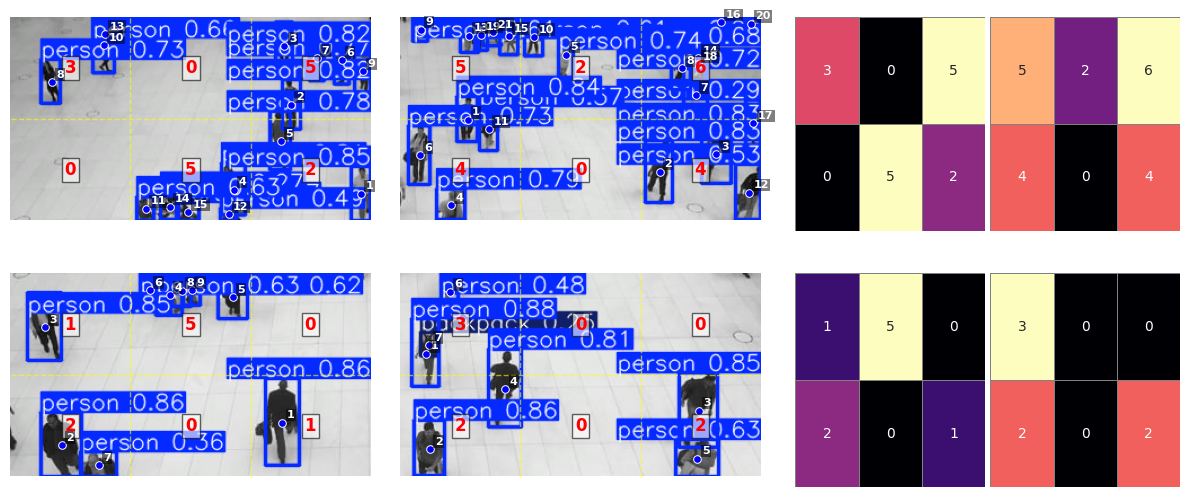

In [11]:
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1]) 


gs_left = gs[0, 0].subgridspec(2, 2) 
gs_right = gs[0, 1].subgridspec(2, 2)
# total_grid_counts = []
count_dt = dict()


for i in range (len(images_splits)) :
    
    grid_cols = 3
    grid_rows = 2
    
    pad_right = 300  # px để dành cho heatmap bên phải  
    res = results[i]
    img_split, left, top = images_splits[i] 
    if res and len(res) > 0:

        count_dt[f'Zone{i+1}'] = len(res[0].boxes)

        result = res[0]
        boxes = result.boxes

        ax_img = fig.add_subplot(gs_left[i//2, i%2])
        ax_heatmap = fig.add_subplot(gs_right[i//2, i%2])
        # 0 - 0 , 0 - 1, 1 - 0, 1 - 1
        # ax_img = axs[i//2, i%2] 

        im_bgr = result.plot() 
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB) 
        h, w = im_rgb.shape[:2]

        # Kích thước mỗi ô
        cell_w = w / grid_cols
        cell_h = h / grid_rows
        
        # Ma trận đếm (rows x cols)
        grid_counts, centers = count_in_roi(boxes, im_rgb.shape, grid_cols, grid_rows, pad_right)
        # total_grid_counts.append(grid_counts)
        # Ghi chú vị trí:   
        # 0:1, 0:2 i = 0
        # 0:1, 2:5 i = 1    
        # 1:3, 0:2 i = 2    
        # 1:3, 2:5 i = 3    
        
        ax_img.imshow(im_rgb)
        ax_img.axis('off') 
        
        for r in range(1, grid_rows):
            y = int(r * cell_h)
            ax_img.plot([0, w], [y, y], color='yellow', linewidth=1, linestyle='--', alpha=0.6)
        for c in range(1, grid_cols):
            x = int(c * cell_w)
            ax_img.plot([x, x], [0, h], color='yellow', linewidth=1, linestyle='--', alpha=0.6)
        
        
        if len(centers) > 0:
            xs = [c[0] for c in centers]
            ys = [c[1] for c in centers]
            ax_img.scatter(xs, ys, c='blue', s=30, edgecolors='white', linewidths=0.7, zorder=3)
            for idx, (cx_box, cy_box) in enumerate(centers):
                ax_img.text(cx_box + 4, cy_box - 4, str(idx+1), color='white', fontsize=8, weight='bold', zorder=4,
                            bbox=dict(facecolor='black', alpha=0.5, pad=1, edgecolor='none'))
        for r in range(grid_rows):
            for c in range(grid_cols):
                cx = int((c + 0.5) * cell_w)
                cy = int((r + 0.5) * cell_h)
                count = grid_counts[r, c]
                ax_img.text(cx, cy, str(count), color='red', fontsize=12, fontweight='bold',
                             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, pad=2))

        sns.heatmap(grid_counts, ax=ax_heatmap, annot=True, fmt='d', cmap='magma', cbar=False,
                xticklabels=False, yticklabels=False, linewidths=0.5, linecolor='gray')

        
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## Add data into Sqlite3

In [ ]:
# connect db sqlite
try: 
    conn = sqlite3.Connection(database= os.path.join(ROOT, 'data', 'test.db'))
except Exception as e: 
    print(f"ERROR: {e}")
    

In [ ]:
# Create table
cursor = conn.cursor() 
camera = '''CREATE TABLE 
            IF NOT EXISTS camera 
            (id INTERGER PRIMARY KEY, 
             zone TEXT, 
             count INTERGER
            );'''
cursor.execute(camera)
conn.commit()

In [ ]:
# insert data into table
for key in count_dt: 
    insert = '''INSERT INTO camera (zone, count) VALUES (? , ?);'''
    cursor.execute(insert, (key, count_dt[key]))
    conn.commit() 


In [ ]:
# Export data as dataframe
cursor.execute('''SELECT * FROM camera;''')
results= cursor.fetchall()
df = pd.DataFrame(results, columns = ['id', 'zone', 'count'])
print(df)

     id   zone  count
0  None  Zone1     15
1  None  Zone2     21
2  None  Zone3      9
3  None  Zone4      7


## Add data into Postgres

In [ ]:
try:
    # Connect to the School database
    conn = psycopg2.connect(
        dbname="demo",
        user="postgres",
        password="12345",
        host="127.0.0.1"
    )
except Exception as e:
    print("Unable to connect to the database:", e)
    exit(1)

In [ ]:
conn.rollback()
cursor = conn.cursor()
cursor.execute('''SELECT * FROM test''')
rows = cursor.fetchall()
for row in rows:
    print(row)

In [ ]:
camera= '''CREATE TABLE IF NOT EXISTS camera (
            id_camera SERIAL PRIMARY KEY,
            zone VARCHAR(50),
            count INT
            );'''
cursor.execute(camera)
conn.commit()